In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import torch
from torch import nn

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance

import pickle
import re

Load data

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv('../data/notebooks/features_selected.csv')
df

,year,fight_time_avg_diff,days_since_debut_diff,win_pct_before_diff,knockdown_avg_diff,sig_strikes_landed_per_minute_diff,takedowns_avg_diff,days_since_last_win_diff,avg_ground_strikes_diff,avg_ground_attempts_diff,avg_body_strikes_diff,control_time_roll_5_diff,avg_clinch_strikes_diff,avg_sub_attempts_diff,takedowns_ema_diff,avg_body_attempts_diff,avg_clinch_attempts_diff,avg_takedowns_diff,avg_time_diff,takedowns_success_rate_roll_5_diff,weight_diff,takedown_attempts_ema_diff,avg_rounds_diff,submission_avg_diff,avg_takedown_attempts_diff,avg_leg_attempts_diff,reach_diff,avg_knockdowns_diff,losses_before_diff,head_strikes_ema_diff,avg_leg_strikes_diff,knockdowns_ema_diff,avg_sig_strikes_diff,sig_strikes_ema_diff,takedown_attempts_roll_5_diff,avg_head_strikes_diff,head_attempts_ema_diff,total_fights_before_diff,total_strikes_ema_diff,avg_distance_attempts_diff,total_strikes_attempts_ema_diff,avg_distance_diff,sig_attempts_roll_5_diff,avg_head_attempts_diff,leg_reach_diff,avg_total_strikes_diff,avg_total_strikes_attempts_diff,total_strikes_roll_5_diff,total_strikes_attempts_roll_5_diff,sig_attempts_ema_diff,takedowns_roll_5_diff,sig_strikes_roll_5_diff,avg_sig_attempts_diff,sig_strikes_absorbed_per_minute_diff,wins_before_diff,month,win_streak_diff,height_diff,knockdowns_roll_5_diff,wins_last_365_days_diff,fights_last_365_days_diff,lose_streak_diff,wins_last_3_diff,winner
0,1994,-630.0,-280,0.000,0.00,-1.0,0.00,0.0,-1.428571,-1.857143,-0.714286,0.000000,-1.714286,-0.285714,0.849900,-1.428571,-2.857143,0.928571,-119.214286,0.400000,-8.402581,0.733449,0.000000,-0.76,1.571429,-1.571429,-3.21178,0.000000,0,-3.448263,-0.714286,0.000000,-3.714286,-5.500982,1.600000,-2.285714,-6.478263,-5,-35.165021,-2.142857,-40.963617,-0.571429,-8.000000,-3.857143,-0.597872,-30.000000,-33.571429,-17.800000,-22.000000,-10.764280,1.100000,-4.000000,-6.857143,-1.0,-5,12,-5,-2.864692,0.000000,-5,-5,0,-1,1
1,1995,-333.0,-98,-0.167,-0.31,-1.0,-0.94,-210.0,-1.833333,0.333333,-2.500000,0.000000,-1.333333,0.166667,0.072030,-2.333333,-1.166667,0.166667,-7.166667,0.130000,-37.402581,-0.011880,0.000000,-2.52,0.166667,-0.333333,-3.21178,0.000000,1,-0.751400,-0.333333,0.000000,-3.166667,-3.604400,0.300000,-0.333333,1.137300,4,2.675300,-0.500000,9.375700,0.000000,-0.300000,1.333333,-2.297872,3.166667,9.666667,6.100000,14.300000,-1.568700,0.200000,-2.600000,-1.333333,-4.0,3,7,1,-2.864692,0.000000,3,4,0,1,1
2,1995,0.0,0,-0.083,0.00,0.0,0.00,98.0,6.666667,10.333333,0.000000,0.000000,0.416667,-1.500000,0.700000,0.000000,1.416667,0.666667,-258.166667,0.666667,0.000000,-0.543000,0.000000,0.00,-0.333333,0.000000,0.00000,0.000000,0,6.960000,0.000000,0.000000,6.333333,6.960000,-0.333333,6.333333,10.350000,-1,-2.400000,-1.916667,0.000000,-0.750000,9.833333,9.833333,0.000000,1.000000,3.916667,1.000000,3.916667,10.350000,0.666667,6.333333,9.833333,0.0,-1,7,-2,0.000000,0.000000,-1,-1,1,0,1
3,1995,0.0,56,-0.250,0.00,0.0,0.00,0.0,0.000000,-0.500000,-0.500000,0.000000,1.000000,-2.000000,0.300000,-0.250000,2.250000,0.000000,-399.750000,0.333333,0.000000,0.300000,0.000000,0.00,0.000000,-1.250000,0.00000,0.250000,1,3.030000,-0.500000,0.490000,1.250000,0.730000,0.333333,2.250000,8.420000,2,-1.400000,2.000000,-0.030000,0.250000,2.000000,5.250000,0.000000,9.250000,11.250000,-1.666667,-2.333333,5.100000,0.333333,-0.333333,3.750000,0.0,1,9,0,0.000000,0.333333,1,2,0,1,1
4,1995,0.0,-154,0.200,0.00,0.0,0.00,0.0,3.000000,4.500000,0.500000,0.000000,0.550000,0.100000,0.300000,0.500000,0.400000,0.500000,169.500000,0.333333,0.000000,-0.870100,0.000000,0.00,-0.250000,9.750000,0.00000,0.250000,-1,1.840000,6.750000,0.210000,10.450000,8.350000,-0.666667,3.200000,3.830000,-2,5.750000,11.950000,12.570000,6.900000,19.933333,6.600000,0.000000,8.900000,16.550000,11.733333,21.466667,13.420000,0.333333,11.866667,16.850000,0.0,-1,12,0,0.000000,0.333333,-1,-3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Split data

In [4]:
X = df.drop('winner', axis=1)
y = df['winner']

print(X.shape, y.shape)

(4584, 63) (4584,)


In [5]:
# Split chronologically on the sorted data
split_idx = int(len(df) * 0.8)
train_indices = df.index[:split_idx]
test_indices = df.index[split_idx:]

# Split features and target
X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

In [6]:
print(X_train.shape, X_test.shape)

(3667, 63) (917, 63)


Scale data

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Note: only transform, don't fit

# Save the fitted scaler
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Convert back to DataFrames if needed
X_train = pd.DataFrame(X_train, columns=X.columns, index=train_indices)
X_test = pd.DataFrame(X_test, columns=X.columns, index=test_indices)

In [8]:
X_train

,year,fight_time_avg_diff,days_since_debut_diff,win_pct_before_diff,knockdown_avg_diff,sig_strikes_landed_per_minute_diff,takedowns_avg_diff,days_since_last_win_diff,avg_ground_strikes_diff,avg_ground_attempts_diff,avg_body_strikes_diff,control_time_roll_5_diff,avg_clinch_strikes_diff,avg_sub_attempts_diff,takedowns_ema_diff,avg_body_attempts_diff,avg_clinch_attempts_diff,avg_takedowns_diff,avg_time_diff,takedowns_success_rate_roll_5_diff,weight_diff,takedown_attempts_ema_diff,avg_rounds_diff,submission_avg_diff,avg_takedown_attempts_diff,avg_leg_attempts_diff,reach_diff,avg_knockdowns_diff,losses_before_diff,head_strikes_ema_diff,avg_leg_strikes_diff,knockdowns_ema_diff,avg_sig_strikes_diff,sig_strikes_ema_diff,takedown_attempts_roll_5_diff,avg_head_strikes_diff,head_attempts_ema_diff,total_fights_before_diff,total_strikes_ema_diff,avg_distance_attempts_diff,total_strikes_attempts_ema_diff,avg_distance_diff,sig_attempts_roll_5_diff,avg_head_attempts_diff,leg_reach_diff,avg_total_strikes_diff,avg_total_strikes_attempts_diff,total_strikes_roll_5_diff,total_strikes_attempts_roll_5_diff,sig_attempts_ema_diff,takedowns_roll_5_diff,sig_strikes_roll_5_diff,avg_sig_attempts_diff,sig_strikes_absorbed_per_minute_diff,wins_before_diff,month,win_streak_diff,height_diff,knockdowns_roll_5_diff,wins_last_365_days_diff,fights_last_365_days_diff,lose_streak_diff,wins_last_3_diff
0,-4.294753,-3.369498,0.008598,0.106160,-0.009440,-0.661444,0.065559,-0.058367,-0.129316,-0.108526,-0.095111,0.032124,-0.294780,-0.405952,0.590927,-0.139761,-0.358288,0.692616,-1.792982,1.410381,-0.614248,0.263294,0.078688,-0.892007,0.536297,-0.154907,-0.974114,0.032167,0.171846,-0.133615,-0.070113,0.007551,-0.130842,-0.144029,0.499289,-0.117721,-0.071483,-0.476745,-0.926695,-0.018630,-0.574357,-0.003975,-0.066550,-0.061562,-0.247447,-0.917669,-0.566824,-0.449796,-0.282351,-0.114625,0.731674,-0.085279,-0.100030,-0.802378,-0.866370,1.516194,-2.290375,-1.156854,0.017443,-4.689914,-4.322071,0.094637,-1.046976
1,-4.095791,-1.740575,0.143693,-0.590292,-0.651609,-0.661444,-0.530282,-0.172053,-0.185649,0.099443,-0.381449,0.032124,-0.230553,0.243010,0.086448,-0.244112,-0.149826,0.173178,-0.101886,0.469658,-2.899401,0.044696,0.078688,-2.999802,0.100622,0.007004,-0.974114,0.032167,0.510096,0.022499,-0.006949,0.007551,-0.104806,-0.066877,0.124504,0.014676,0.089664,0.878350,0.130185,0.016142,0.211697,0.026565,0.068016,0.064615,-1.042629,0.127406,0.203380,0.214957,0.279843,0.047208,0.158439,-0.028038,0.012077,-2.943814,1.019917,0.049671,0.488693,-1.156854,0.017443,2.734581,3.486190,0.094637,1.023823
2,-4.095791,0.085793,0.216437,-0.239981,-0.009440,0.029456,0.065559,-0.005313,0.997343,1.048869,0.019424,0.032124,0.064491,-2.147903,0.493711,0.025004,0.168738,0.514059,-3.890142,2.339491,0.047861,-0.111077,0.078688,0.018178,-0.054449,0.050596,0.032444,0.032167,0.171846,0.468890,0.048319,0.007551,0.346871,0.362877,-0.058084,0.466765,0.284606,0.125520,-0.011568,-0.013843,0.065294,-0.013519,0.245107,0.271244,0.032210,0.059134,0.100955,0.073106,0.119032,0.256966,0.455672,0.337213,0.238707,-0.088566,0.076773,0.049671,-0.900841,-0.005791,0.017443,-0.977666,-0.851733,1.124409,-0.011577
3,-4.095791,0.085793,0.258004,-0.936433,-0.009440,0.029456,0.065559,-0.058367,0.069506,0.020324,-0.060751,0.032124,0.162839,-2.865176,0.234296,-0.003830,0.271501,0.059551,-6.027010,1.178104,0.047861,0.136168,0.078688,0.018178,0.048931,-0.112872,0.032444,0.705764,0.510096,0.241393,-0.034584,1.186808,0.105184,0.109444,0.134114,0.189861,0.243767,0.577218,0.016362,0.069055,0.064825,0.039926,0.108211,0.159827,0.032210,0.319090,0.231584,-0.001064,0.022235,0.164571,0.243363,0.064637,0.115244,-0.088566,0.548345,0.636280,0.025515,-0.005791,0.820516,0.878457,1.751021,0.094637,1.023823
4,-4.095791,0.085793,0.102125,0.940234,-0.009440,0.029456,0.065559,-0.058367,0.487033,0.495037,0.099598,0.032124,0.086971,0.147373,0.234296,0.082671,0.043368,0.400432,2.564482,1.178104,0.047861,-0.207013,0.078688,0.018178,-0.028604,1.32564

Find best models using GridSearch

In [9]:
def tune_models(model_param_list, X_train, y_train, scoring='accuracy', cv=5):
    """
    Performs GridSearchCV for each model and parameter grid.

    Args:
        model_param_list (list): List of tuples: (model_name, model_instance, param_grid)
        X_train (DataFrame): Training features
        y_train (Series or array): Training labels
        scoring (str): Scoring metric for GridSearchCV (default: 'accuracy')
        cv (int): Number of cross-validation folds (default: 5)

    Returns:
        dict: model_name -> best GridSearchCV result
    """

    best_models = {}

    start_time = time.time()

    for name, model, param_grid in model_param_list:
        start_iteration_time = time.time()
        grid = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)

        print(f"Best score for {name}: {grid.best_score_:.4f}")
        print(f"Best parameters for {name}: {grid.best_params_}")
        end_iteration_time = time.time()
        print(f"Tuning completed in {end_iteration_time - start_iteration_time:.2f} seconds.")    

        best_models[name] = grid
    
    end_time = time.time()
    print(f"Overall tuning completed in {end_time - start_time:.2f} seconds.")

    return best_models

Parameters for each model

In [10]:
model_param_list = [
    (
        "LogisticRegression",
        LogisticRegression(),
        [
                # L2 penalty
            {
                'penalty': ['l2'],
                'C': [0.01, 0.1, 1, 10],
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
            },
                # L1 penalty
            {
                'penalty': ['l1'],
                'C': [0.01, 0.1, 1, 10],
                'solver': ['liblinear', 'saga']
            },
                # ElasticNet penalty
            {
                'penalty': ['elasticnet'],
                'C': [0.01, 0.1, 1, 10],
                'solver': ['saga'],
                'l1_ratio': [0.0, 0.5, 1.0]
            },
                # No penalty
            {
                'penalty': [None],
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
            }
        ]
    ),
    (
        "SVC",
        SVC(),
        {
            'C': [0.1, 1],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale'],
            'degree': [3] 
        }
    ),
    (
        "SGDClassifier",
        SGDClassifier(),
        {
            'alpha': [0.0001, 0.001, 0.01],
            'loss': ['hinge', 'log_loss', 'squared_hinge', 'perceptron'],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'l1_ratio': [0.15, 0.5, 0.85],  # only for elasticnet
            'max_iter': [1000, 2000, 5000]
        }  
    ),
    (
        "GaussianNB",
        GaussianNB(),
        {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    ),
    (
        "KNeighborsClassifier",
        KNeighborsClassifier(),
        {
        'n_neighbors': [3, 5, 7, 9, 12, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],  # 1=Manhattan, 2=Euclidean
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [20, 30, 40]
        }
    ),
    (
        "DecisionTreeClassifier",
        DecisionTreeClassifier(),
        {
            'criterion': ['gini'],
            'max_depth': [None, 6, 8, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt', 'log2']
        }
    ),
    (
        "RandomForestClassifier",
        RandomForestClassifier(),
        {
            'n_estimators': [100, 200],
            'criterion': ['gini'],
            'max_depth': [None, 8, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    (
        "AdaBoostClassifier",
        AdaBoostClassifier(),
        {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1]
        }
    ),
    (
        "GradientBoostingClassifier",
        GradientBoostingClassifier(),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'subsample': [0.8, 1.0],
            'max_features': ['sqrt', 'log2']
        }
    ),
    (
        "XGBClassifier",
        XGBClassifier(),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0, 0.1],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [1, 1.5]
        }
    )
]

In [11]:
best_models = tune_models(model_param_list, X_train, y_train, scoring='accuracy', cv=5)

Best score for LogisticRegression: 0.6613
Best parameters for LogisticRegression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuning completed in 12.05 seconds.
Best score for SVC: 0.6624
Best parameters for SVC: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Tuning completed in 5.74 seconds.
Best score for SGDClassifier: 0.6730
Best parameters for SGDClassifier: {'alpha': 0.01, 'l1_ratio': 0.85, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l1'}
Tuning completed in 59.11 seconds.
Best score for GaussianNB: 0.6204
Best parameters for GaussianNB: {'var_smoothing': 1e-09}
Tuning completed in 0.18 seconds.
Best score for KNeighborsClassifier: 0.6179
Best parameters for KNeighborsClassifier: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Tuning completed in 39.01 seconds.
Best score for DecisionTreeClassifier: 0.6204
Best parameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_sam

Neural Network

In [12]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Is CUDA supported by this system? True
CUDA version: 11.8


'cuda'

Convert X and y to numpy arrays for calculations

In [13]:
X_train_torch = torch.from_numpy(X_train.to_numpy()).type(torch.float)
y_train_torch = torch.from_numpy(y_train.to_numpy()).type(torch.float)
X_test_torch = torch.from_numpy(X_test.to_numpy()).type(torch.float)
y_test_torch = torch.from_numpy(y_test.to_numpy()).type(torch.float)

# View the first five samples
X_train_torch[:5], y_train_torch[:5]

(tensor([[-4.2948e+00, -3.3695e+00,  8.5981e-03,  1.0616e-01, -9.4399e-03,
          -6.6144e-01,  6.5559e-02, -5.8367e-02, -1.2932e-01, -1.0853e-01,
          -9.5111e-02,  3.2124e-02, -2.9478e-01, -4.0595e-01,  5.9093e-01,
          -1.3976e-01, -3.5829e-01,  6.9262e-01, -1.7930e+00,  1.4104e+00,
          -6.1425e-01,  2.6329e-01,  7.8688e-02, -8.9201e-01,  5.3630e-01,
          -1.5491e-01, -9.7411e-01,  3.2167e-02,  1.7185e-01, -1.3361e-01,
          -7.0113e-02,  7.5507e-03, -1.3084e-01, -1.4403e-01,  4.9929e-01,
          -1.1772e-01, -7.1483e-02, -4.7674e-01, -9.2669e-01, -1.8630e-02,
          -5.7436e-01, -3.9754e-03, -6.6550e-02, -6.1562e-02, -2.4745e-01,
          -9.1767e-01, -5.6682e-01, -4.4980e-01, -2.8235e-01, -1.1462e-01,
           7.3167e-01, -8.5279e-02, -1.0003e-01, -8.0238e-01, -8.6637e-01,
           1.5162e+00, -2.2904e+00, -1.1569e+00,  1.7443e-02, -4.6899e+00,
          -4.3221e+00,  9.4637e-02, -1.0470e+00],
         [-4.0958e+00, -1.7406e+00,  1.4369e-01, -

In [14]:
print(X_train_torch.shape)
print(y_train_torch.shape)

torch.Size([3667, 63])
torch.Size([3667])


In [15]:
class Deep(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.network(x)
    
pytorch_model = Deep(input_dim=X_train_torch.shape[1]).to(device)
pytorch_model

Deep(
  (network): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [16]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10)

In [17]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
epochs = 80

X_train_torch, y_train_torch = X_train_torch.to(device), y_train_torch.to(device)
X_test_torch, y_test_torch = X_test_torch.to(device), y_test_torch.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):

    pytorch_model.train()

    # 1 Forward pass
    y_logits = pytorch_model(X_train_torch).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #2 Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train_torch)

    acc = accuracy_fn(y_true = y_train_torch, y_pred=y_pred)

    #3 Optimizer
    optimizer.zero_grad()

    #4 Loss backwards
    loss.backward()

    #5 Optimizer step
    optimizer.step()

    
    # Save training metrics
    train_losses.append(loss.item())
    train_accuracies.append(acc)

    # Testing
    pytorch_model.eval()
    with torch.inference_mode():
        #1 Forward pass
        test_logits = pytorch_model(X_test_torch).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        #2 Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test_torch)
        scheduler.step(test_loss)
        
        test_acc = accuracy_fn(y_true=y_test_torch,
                                y_pred=test_pred)
        
        # Save test metrics
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68928, Accuracy: 53.48% | Test loss: 0.68974, Test acc: 56.27%
Epoch: 10 | Loss: 0.63481, Accuracy: 62.75% | Test loss: 0.67118, Test acc: 56.27%
Epoch: 20 | Loss: 0.59033, Accuracy: 65.26% | Test loss: 0.64941, Test acc: 59.65%
Epoch: 30 | Loss: 0.54881, Accuracy: 71.31% | Test loss: 0.64262, Test acc: 64.99%
Epoch: 40 | Loss: 0.50203, Accuracy: 74.69% | Test loss: 0.64083, Test acc: 65.21%
Epoch: 50 | Loss: 0.46135, Accuracy: 78.46% | Test loss: 0.65557, Test acc: 64.34%
Epoch: 60 | Loss: 0.42166, Accuracy: 81.02% | Test loss: 0.67246, Test acc: 63.90%
Epoch: 70 | Loss: 0.40026, Accuracy: 82.49% | Test loss: 0.68869, Test acc: 63.25%


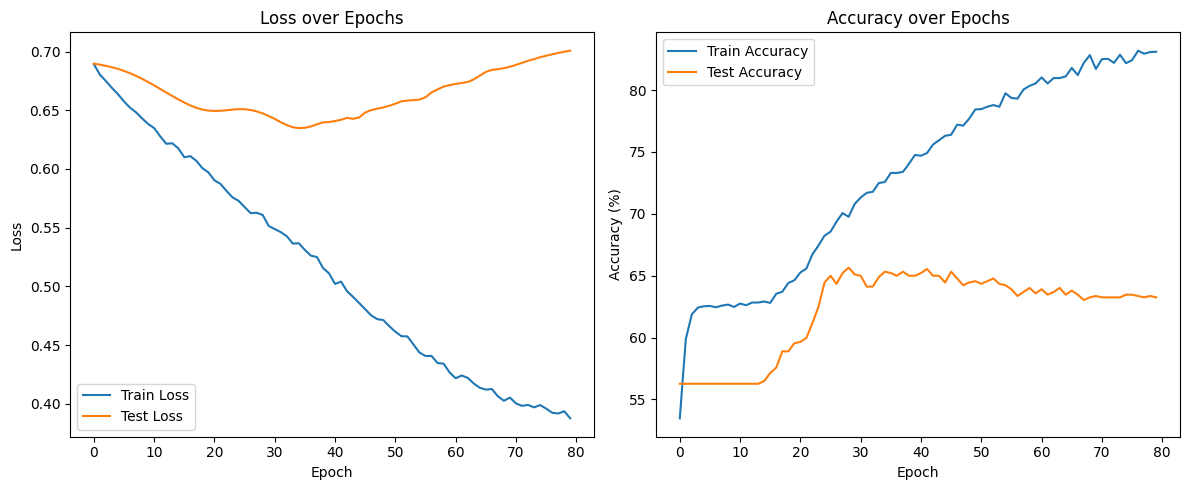

In [19]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
def evaluate(model, X, y):
    model.eval()
    with torch.inference_mode():
        logits = model(X).squeeze()
        preds = torch.round(torch.sigmoid(logits))
        loss = loss_fn(logits, y)
        acc = accuracy_fn(y_true=y, y_pred=preds)
    return loss.item(), acc

test_loss, test_acc = evaluate(pytorch_model, X_test_torch, y_test_torch)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.7007, Test Accuracy: 63.25%


In [21]:
# Move data back to CPU if it's on GPU

y_true1 = y_test_torch.cpu().numpy()
y_scores1 = pytorch_model(X_test_torch).squeeze().detach().cpu()
y_pred1 = torch.round(torch.sigmoid(y_scores1)).numpy()

# Print classification report
print(classification_report(y_true1, y_pred1))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true1, y_pred1))


              precision    recall  f1-score   support

         0.0       0.57      0.68      0.62       401
         1.0       0.70      0.60      0.65       516

    accuracy                           0.63       917
   macro avg       0.64      0.64      0.63       917
weighted avg       0.64      0.63      0.63       917

Confusion Matrix:
[[272 129]
 [208 308]]


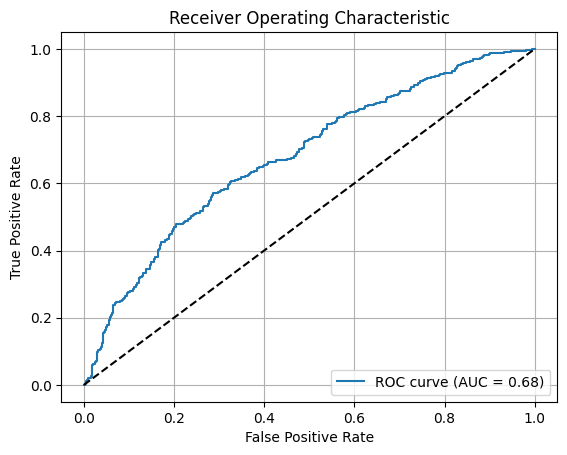

In [22]:
fpr, tpr, thresholds = roc_curve(y_true1, y_scores1.numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Evaluate Models

In [23]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics on test
    metrics = {
        'Model': name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test, y_test_pred, zero_division=0),
        'F1': f1_score(y_test, y_test_pred, zero_division=0)
    }

    # Overfitting check (gap between train/test accuracy)
    metrics['Overfit Gap'] = metrics['Train Accuracy'] - metrics['Test Accuracy']

    return metrics

In [24]:
def evaluate_pytorch_model(model, X_train, y_train, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        # Train predictions
        y_train_logits = model(X_train.to(device)).squeeze()
        y_train_probs = torch.sigmoid(y_train_logits)
        y_train_pred = torch.round(y_train_probs).cpu().numpy()
        y_train_true = y_train.cpu().numpy()

        # Test predictions
        y_test_logits = model(X_test.to(device)).squeeze()
        y_test_probs = torch.sigmoid(y_test_logits)
        y_test_pred = torch.round(y_test_probs).cpu().numpy()
        y_test_true = y_test.cpu().numpy()

    metrics = {
        'Model': 'Neural Network',
        'Train Accuracy': accuracy_score(y_train_true, y_train_pred),
        'Test Accuracy': accuracy_score(y_test_true, y_test_pred),
        'Precision': precision_score(y_test_true, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test_true, y_test_pred, zero_division=0),
        'F1': f1_score(y_test_true, y_test_pred, zero_division=0),
        'Overfit Gap': accuracy_score(y_train_true, y_train_pred) - accuracy_score(y_test_true, y_test_pred)
    }

    return metrics



In [25]:
results = []

for name, grid in best_models.items():
    best_model = grid.best_estimator_
    metrics = evaluate_model(name, best_model, X_train, y_train, X_test, y_test)
    results.append(metrics)

nn_metrics = evaluate_pytorch_model(pytorch_model, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
results.append(nn_metrics)

results_df = pd.DataFrame(results)
results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
results_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1,Overfit Gap
0,LogisticRegression,0.697300,0.679389,0.768116,0.616279,0.683871,0.017911
1,SVC,0.703300,0.677208,0.754630,0.631783,0.687764,0.026091
2,SGDClassifier,0.682302,0.653217,0.700405,0.670543,0.685149,0.029085
10,Neural Network,0.836106,0.632497,0.704805,0.596899,0.646380,0.203609
6,RandomForestClassifier,0.824107,0.616140,0.613889,0.856589,0.715210,0.207967
5,DecisionTreeClassifier,0.691573,0.601963,0.626043,0.726744,0.672646,0.089611
8,GradientBoostingClassifier,0.670030,0.598691,0.590686,0.934109,0.723724,0.071339
4,KNeighborsClassifier,0.700845,0.591058,0.611374,0.750000,0.673629,0.109788
3,GaussianNB,0.631579,0.583424,0.637860,0.600775,0.618762,0.048155
9,XGBClassifier,0.657213,0.579062,0.576471,0.949612,0.717423,0.078151


Plot Confusion Matrix

In [26]:
accuracies = []

# Collect test accuracy for each sklearn model
for name, grid in best_models.items():
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((name, best_model, acc))

# Add PyTorch model
pytorch_model.eval()
with torch.no_grad():
    y_test_logits = pytorch_model(X_test_torch).squeeze()
    y_test_probs = torch.sigmoid(y_test_logits)
    y_test_pred = torch.round(y_test_probs).cpu().numpy()
    y_test_true = y_test_torch.cpu().numpy()
    acc = accuracy_score(y_test_true, y_test_pred)
    accuracies.append(("Neural Network", pytorch_model, acc))

# Sort by accuracy (descending)
accuracies.sort(key=lambda x: x[2], reverse=True)

def plot_all_confusion_matrices(accuracies, X_test, y_test, X_test_torch, y_test_torch, cols=3):
    rows = math.ceil(len(accuracies) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  # flatten so we can index easily

    for idx, (name, model, acc) in enumerate(accuracies):
        ax = axes[idx]

        if name == "Neural Network":
            # PyTorch predictions
            model.eval()
            with torch.no_grad():
                y_test_logits = model(X_test_torch).squeeze()
                y_test_probs = torch.sigmoid(y_test_logits)
                y_test_pred = torch.round(y_test_probs).cpu().numpy()
                y_test_true = y_test_torch.cpu().numpy()
            cm = confusion_matrix(y_test_true, y_test_pred)
        else:
            # Sklearn predictions
            y_test_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_test_pred)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(f"{name}\nAcc: {acc:.2f}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Hide unused subplots if any
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


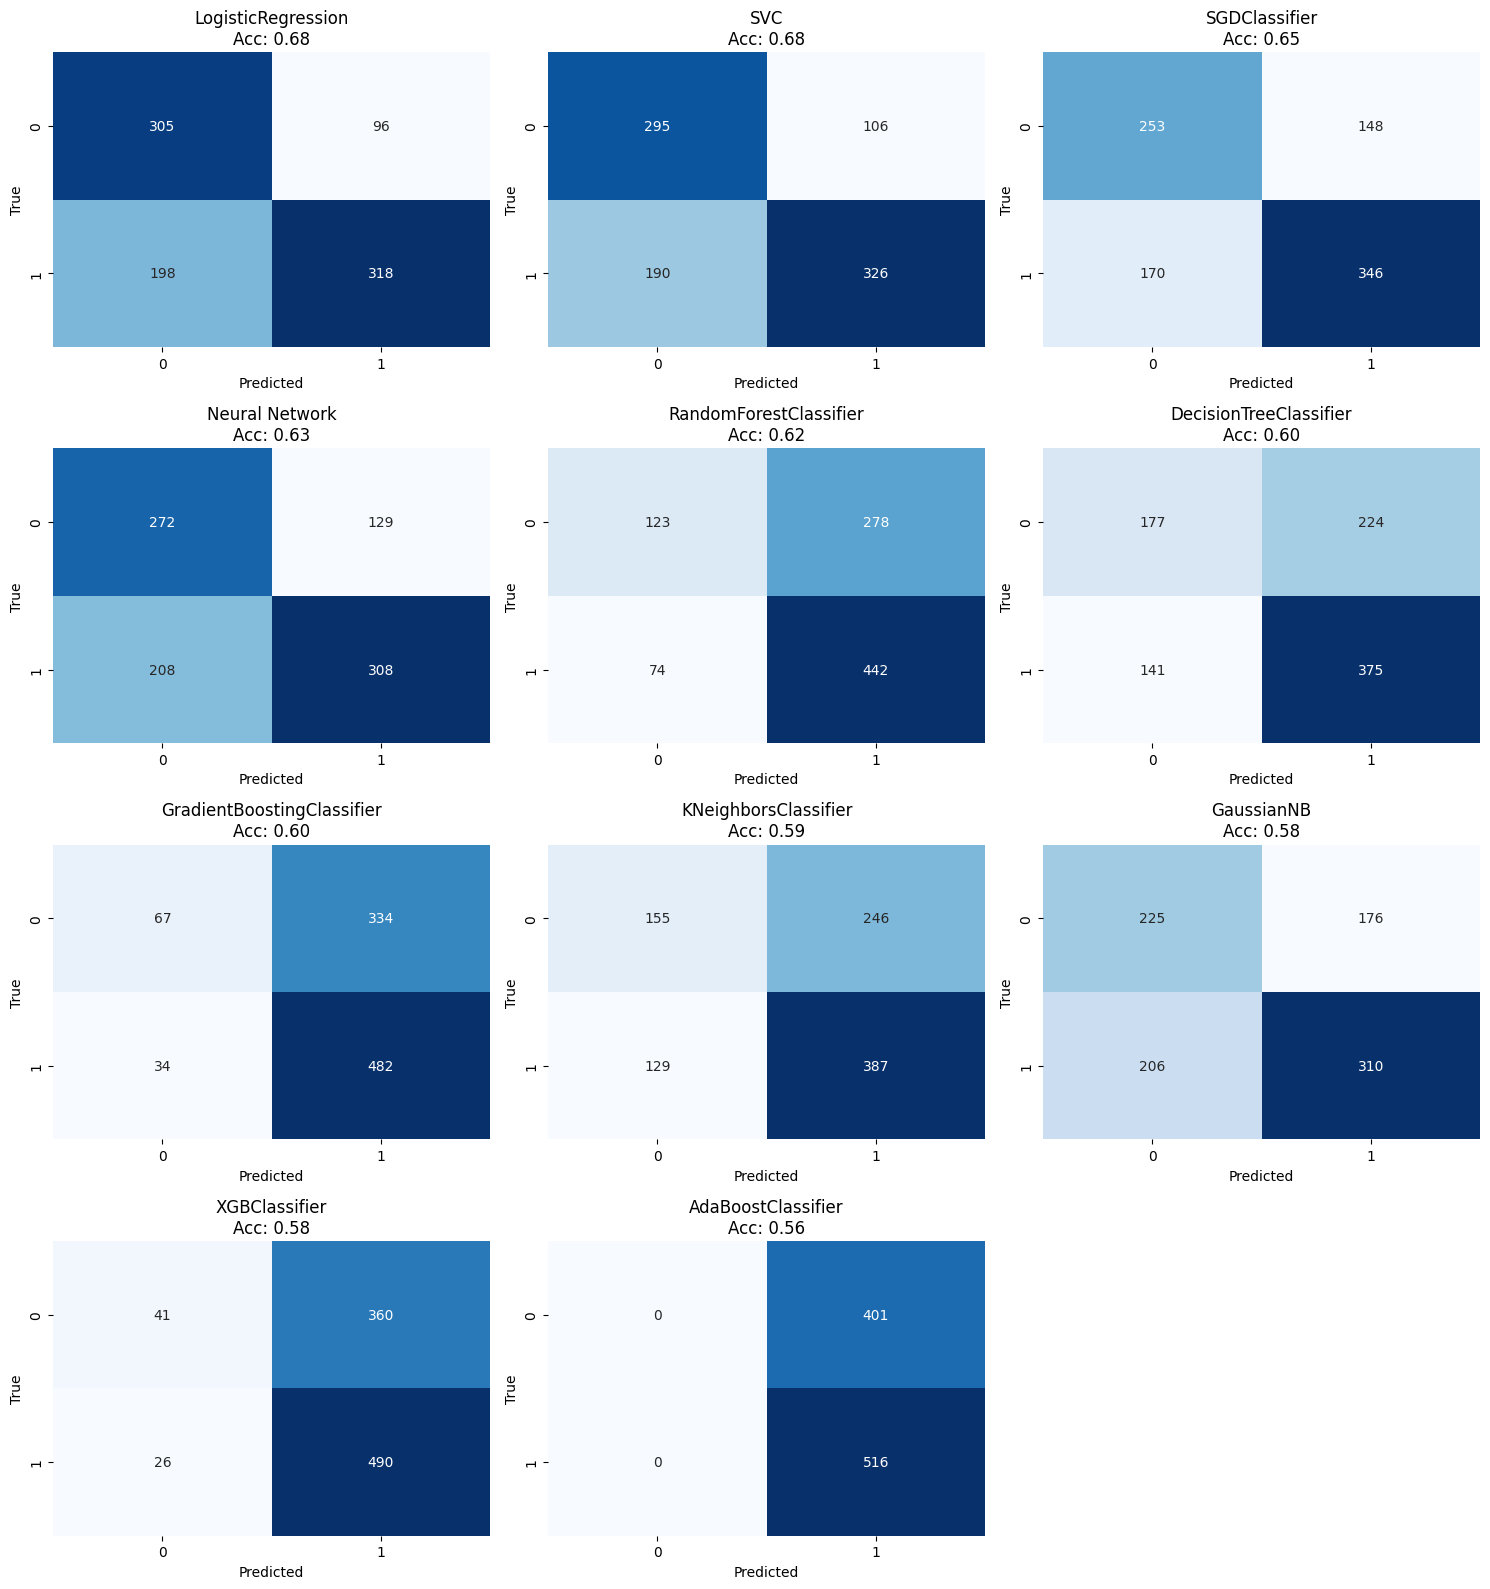

In [27]:
plot_all_confusion_matrices(accuracies, X_test, y_test, X_test_torch, y_test_torch, cols=3)


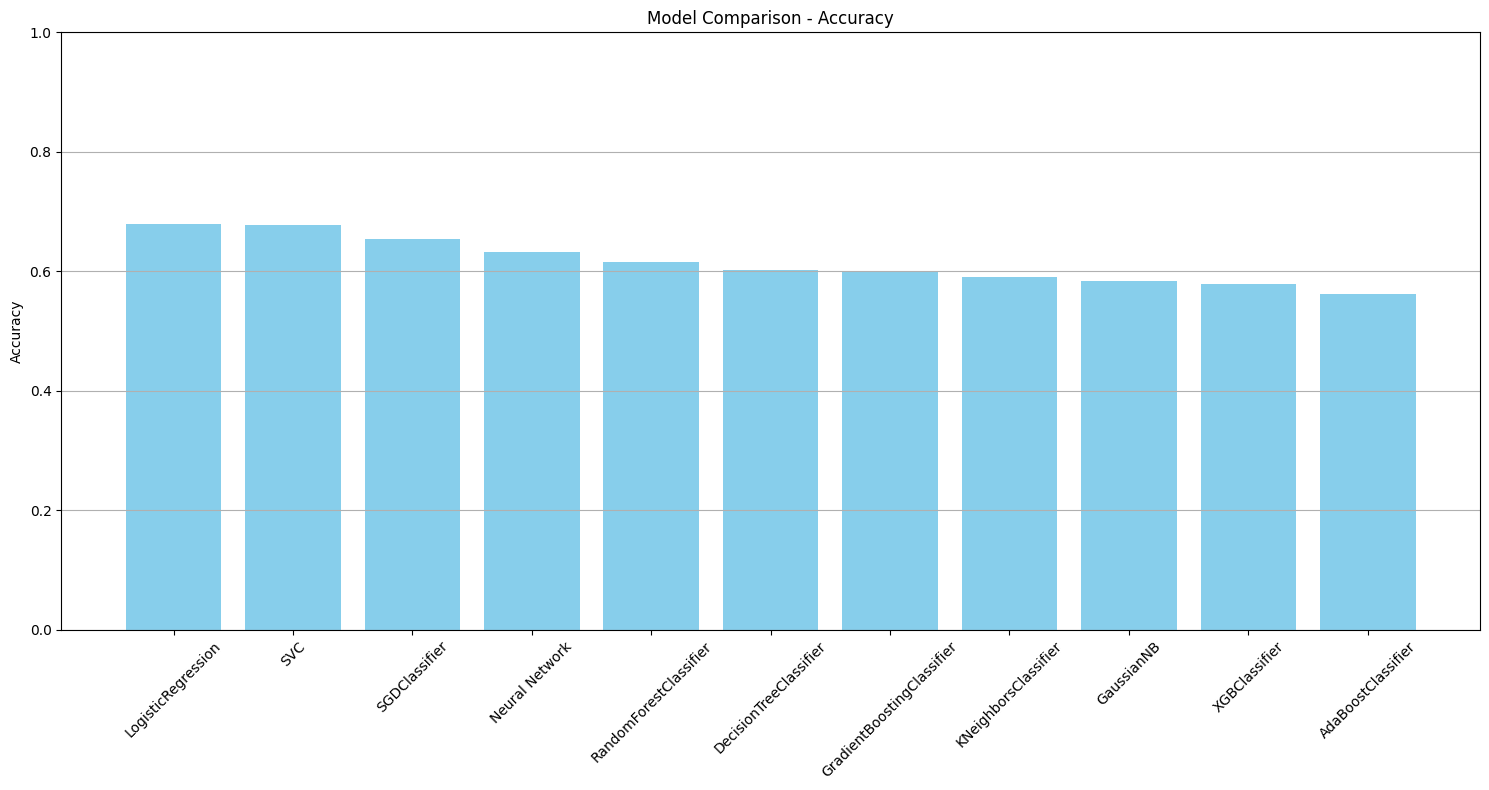

In [28]:
# Bar plot for Accuracy
plt.figure(figsize=(15, 8))
plt.bar(results_df['Model'], results_df['Test Accuracy'], color='skyblue')
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

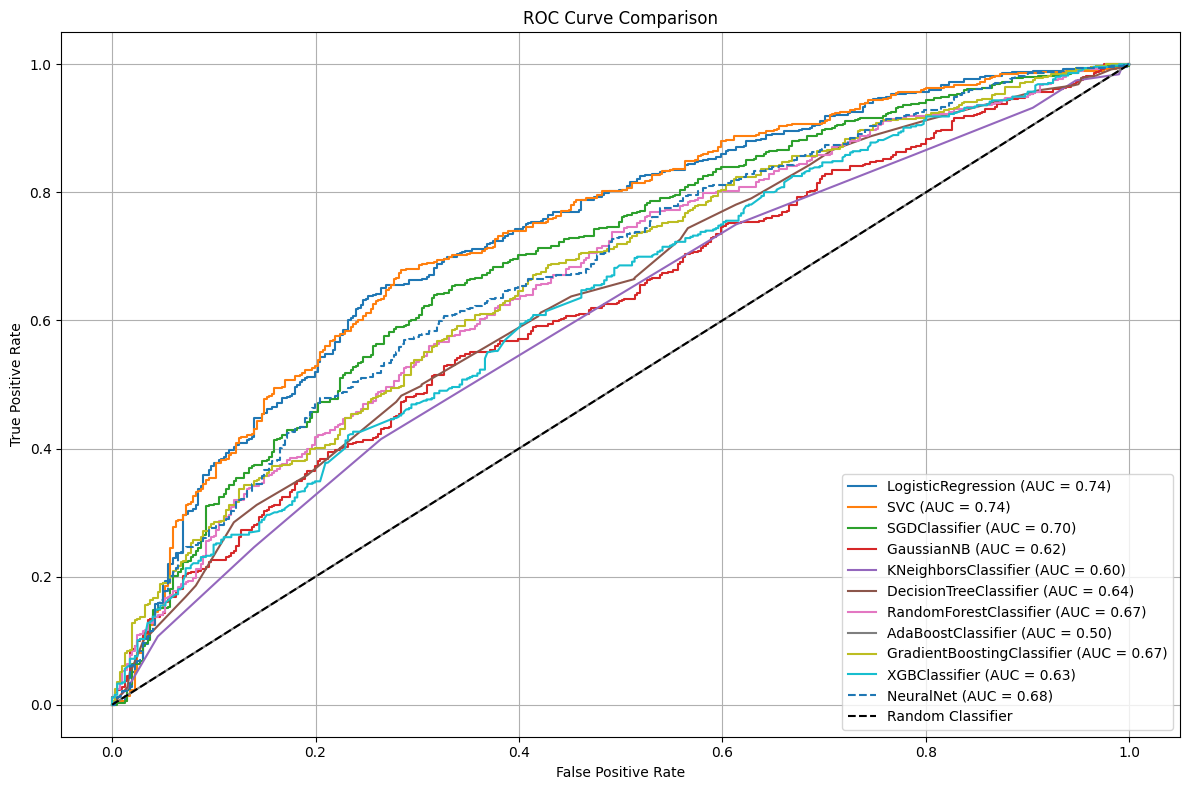

In [29]:
plt.figure(figsize=(12, 8))

# Loop through sklearn models
for name, grid in best_models.items():
    model = grid.best_estimator_
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# NN model (PyTorch)
pytorch_model.eval()
with torch.no_grad():
    y_logits = pytorch_model(X_test_torch)  # X_test is on CUDA
    y_probs = torch.sigmoid(y_logits).squeeze().cpu().numpy()  # move to CPU
    y_true = y_test_torch.squeeze().cpu().numpy()  # move to CPU

fpr_nn, tpr_nn, _ = roc_curve(y_true, y_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, label=f"NeuralNet (AUC = {roc_auc_nn:.2f})", linestyle='--')

# Final plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
def get_feature_importance(model, X, y, feature_names):
    """
    Returns a DataFrame of feature importance for any fitted classifier.
    
    Parameters:
        model: trained classifier
        X: features (DataFrame or numpy array)
        y: target
        feature_names: list of feature names
    
    Returns:
        Pandas DataFrame sorted by importance
    """

    importance = []

    # Case 1: Tree-based models
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_

    # Case 2: Linear models (LogisticRegression, SGDClassifier, LinearSVC, etc.)
    elif hasattr(model, "coef_"):
        importance = np.abs(model.coef_[0])  # take abs to get magnitude

    # Case 3: Models without built-in importance → use permutation importance
    else:
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
        importance = result.importances_mean

    # Create DataFrame
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    return importance_df

# Collect feature importances from all models
importance_dfs = []

for name, grid in best_models.items():
    model = grid.best_estimator_
    imp_df = get_feature_importance(model, X_train, y_train, feature_names=X_train.columns)
    imp_df = imp_df.set_index("Feature")
    imp_df.rename(columns={"Importance": name}, inplace=True)
    importance_dfs.append(imp_df)

# Combine all into one DataFrame, joining on feature names
combined_importance_df = pd.concat(importance_dfs, axis=1)

combined_importance_df


,LogisticRegression,SVC,SGDClassifier,GaussianNB,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,XGBClassifier
Feature,,,,,,,,,,
fight_time_avg_diff,0.471351,0.648991,0.516320,0.005045,0.013799,0.188315,0.048632,0.0,0.086794,0.076073
year,0.409020,0.407955,0.349847,0.021080,0.012899,0.000000,0.116531,1.0,0.268663,0.247066
sig_strikes_landed_per_minute_diff,0.384154,0.506488,0.447229,0.007499,0.010090,0.128236,0.034827,0.0,0.081000,0.052416
knockdown_avg_diff,0.237098,0.372831,0.231479,0.003409,0.006136,0.000000,0.020341,0.0,0.025007,0.033109
sig_strikes_absorbed_per_minute_diff,0.211643,0.225129,0.178158,0.001963,0.004718,0.000000,0.008505,0.0,0.013781,0.028006
...,...,...,...,...,...,...,...,...,...,...
avg_takedowns_diff,0.004988,0.067669,0.000000,0.000791,-0.000355,0.011636,0.020506,0.0,0.022562,0.041694
knockdowns_roll_5_diff,0.004826,0.063670,0.000000,0.001554,0.002618,0.000000,0.009375,0.0,0.001563,0.000000
takedown_attempts_ema_diff,0.003446,0.156662,0.000000,-0.000218,0.000791,0.011983,0.015163,0.0,0.010805,0.020860


In [31]:
def get_pytorch_feature_importance(model, X, y, feature_names=None, n_repeats=5, metric=accuracy_score):
    """
    Compute permutation feature importance for a PyTorch model.
    
    Parameters:
        model: trained PyTorch model (in eval mode)
        X: torch.Tensor of shape (n_samples, n_features), on correct device
        y: torch.Tensor of shape (n_samples,), binary labels (0/1)
        feature_names: list of feature names, or None
        n_repeats: number of shuffles per feature
        metric: function to evaluate model performance (default accuracy)
        
    Returns:
        Pandas DataFrame with features and mean importance (performance drop)
    """
    model.eval()
    baseline_preds = torch.sigmoid(model(X)).squeeze().detach().cpu().numpy() >= 0.5
    baseline_score = metric(y.cpu().numpy(), baseline_preds)
    
    importances = []
    X = X.clone()  # don't modify original

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            # Permute the i-th feature column
            idx = torch.randperm(X_permuted.size(0))
            X_permuted[:, i] = X_permuted[idx, i]
            
            with torch.no_grad():
                preds = torch.sigmoid(model(X_permuted)).squeeze().cpu().numpy() >= 0.5
            score = metric(y.cpu().numpy(), preds)
            scores.append(score)
        
        # Importance = drop in performance after permuting feature i
        mean_score = np.mean(scores)
        importances.append(baseline_score - mean_score)
    
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)
    
    return importance_df

feature_names = X_train.columns.tolist()

importance_df = get_pytorch_feature_importance(
    pytorch_model,
    X_train_torch,  # already on device, tensor shape (n_samples, n_features)
    y_train_torch,  # tensor shape (n_samples,)
    feature_names=feature_names,
    n_repeats=10
)

importance_df

,Feature,Importance
0,fight_time_avg_diff,0.115844
1,sig_strikes_landed_per_minute_diff,0.085056
2,year,0.067058
3,knockdown_avg_diff,0.049659
4,avg_sig_attempts_diff,0.040169
...,...,...
58,sig_strikes_ema_diff,0.019035
59,wins_last_3_diff,0.018707
60,takedowns_ema_diff,0.018162
61,control_time_roll_5_diff,0.011590


In [32]:
# Assuming combined_importance_df is your existing DataFrame with sklearn model importances
# and importance_df is the one returned by get_pytorch_feature_importance

# Set 'Feature' as index for the PyTorch importance df
importance_df = importance_df.set_index("Feature")

# Rename the Importance column to "Neural Network"
importance_df.rename(columns={"Importance": "Neural Network"}, inplace=True)

# Merge with combined_importance_df on the index (Feature names)
combined_importance_df = combined_importance_df.join(importance_df, how='outer')

# Optionally, recompute mean importance including the new model
combined_importance_df["Mean Importance"] = combined_importance_df.mean(axis=1)

# Sort by mean importance descending
combined_importance_df = combined_importance_df.sort_values(by="Mean Importance", ascending=False)

combined_importance_df


,LogisticRegression,SVC,SGDClassifier,GaussianNB,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,XGBClassifier,Neural Network,Mean Importance
Feature,,,,,,,,,,,,
year,0.409020,0.407955,0.349847,0.021080,0.012899,0.000000,0.116531,1.0,0.268663,0.247066,0.067058,0.263647
fight_time_avg_diff,0.471351,0.648991,0.516320,0.005045,0.013799,0.188315,0.048632,0.0,0.086794,0.076073,0.115844,0.197379
sig_strikes_landed_per_minute_diff,0.384154,0.506488,0.447229,0.007499,0.010090,0.128236,0.034827,0.0,0.081000,0.052416,0.085056,0.157909
knockdown_avg_diff,0.237098,0.372831,0.231479,0.003409,0.006136,0.000000,0.020341,0.0,0.025007,0.033109,0.049659,0.089006
sig_strikes_absorbed_per_minute_diff,0.211643,0.225129,0.178158,0.001963,0.004718,0.000000,0.008505,0.0,0.013781,0.028006,0.036051,0.064360
...,...,...,...,...,...,...,...,...,...,...,...,...
avg_time_diff,0.005639,0.036884,0.000000,0.002809,0.004936,0.000000,0.012428,0.0,0.001997,0.014250,0.019307,0.008932
total_fights_before_diff,0.001297,0.013012,0.000000,0.003600,0.003191,0.020397,0.013849,0.0,0.013822,0.000000,0.019335,0.008046
month,0.023997,0.015569,0.000000,0.000355,0.002045,0.000000,0.006916,0.0,0.001135,0.000000,0.025334,0.006850


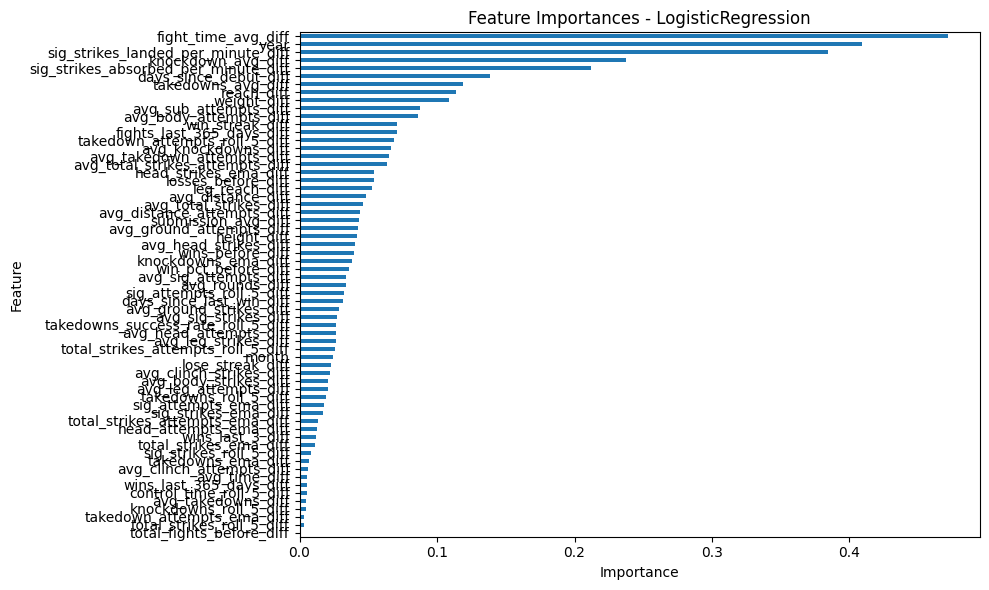

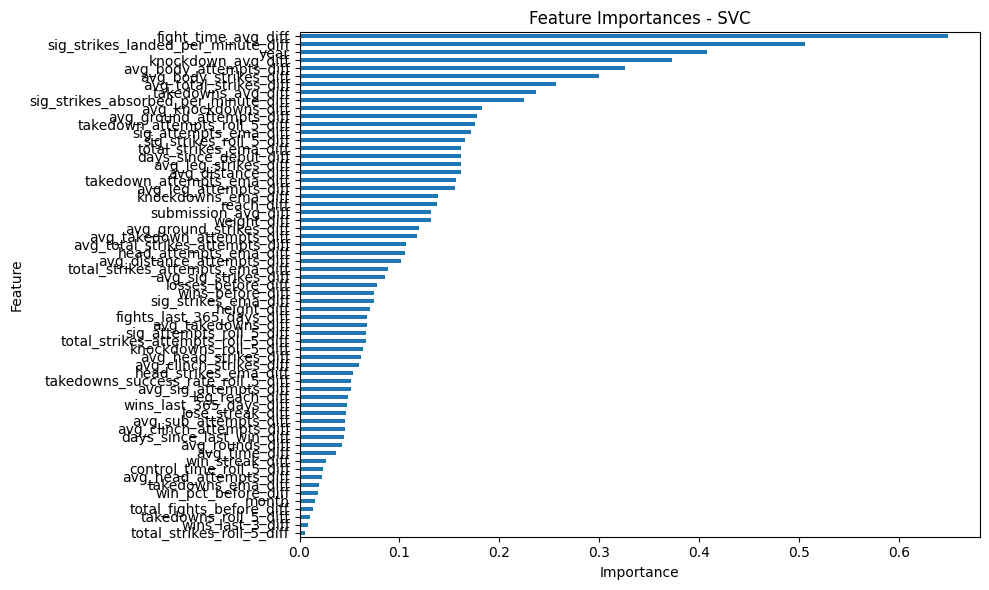

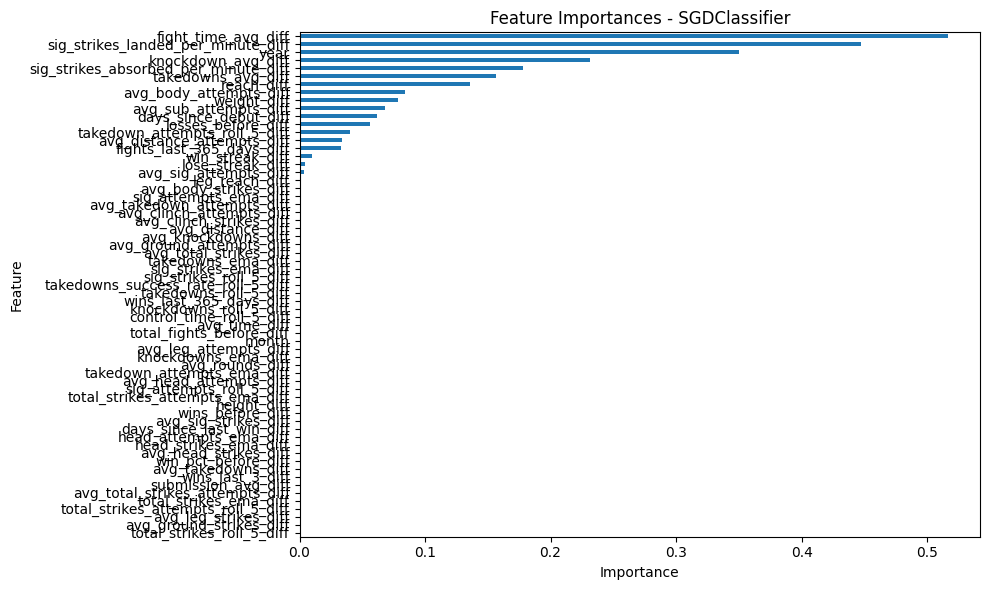

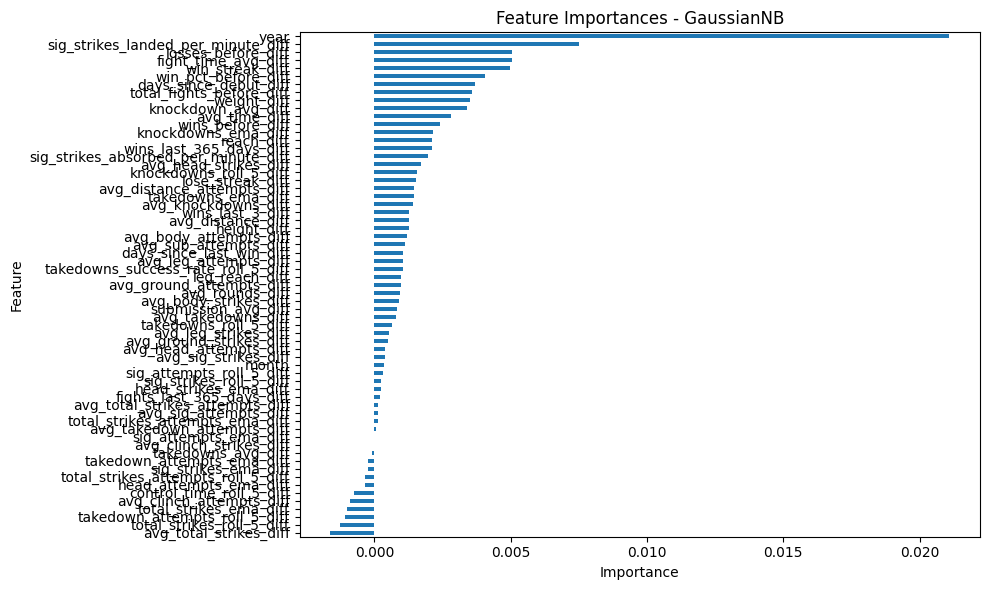

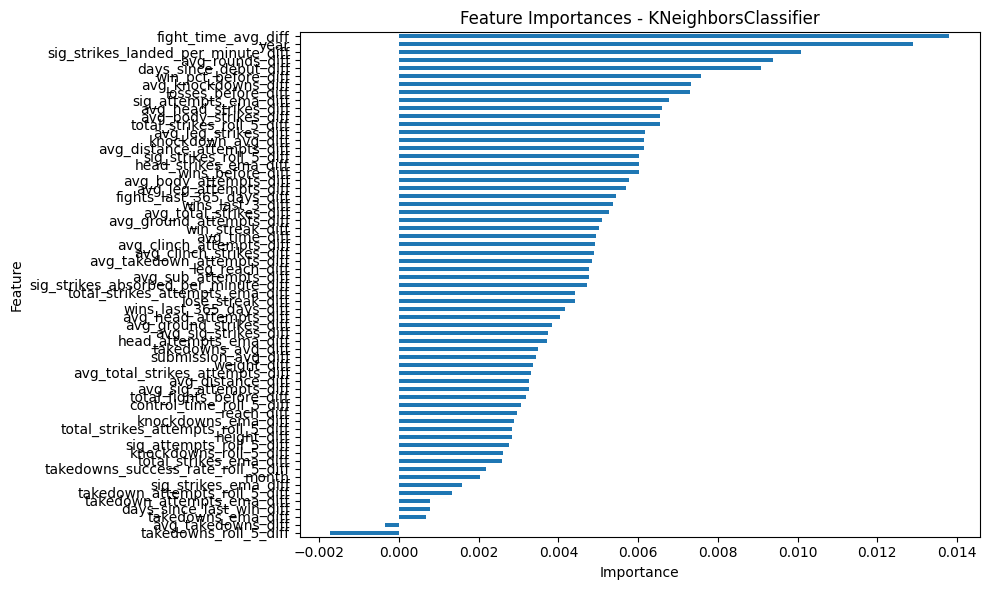

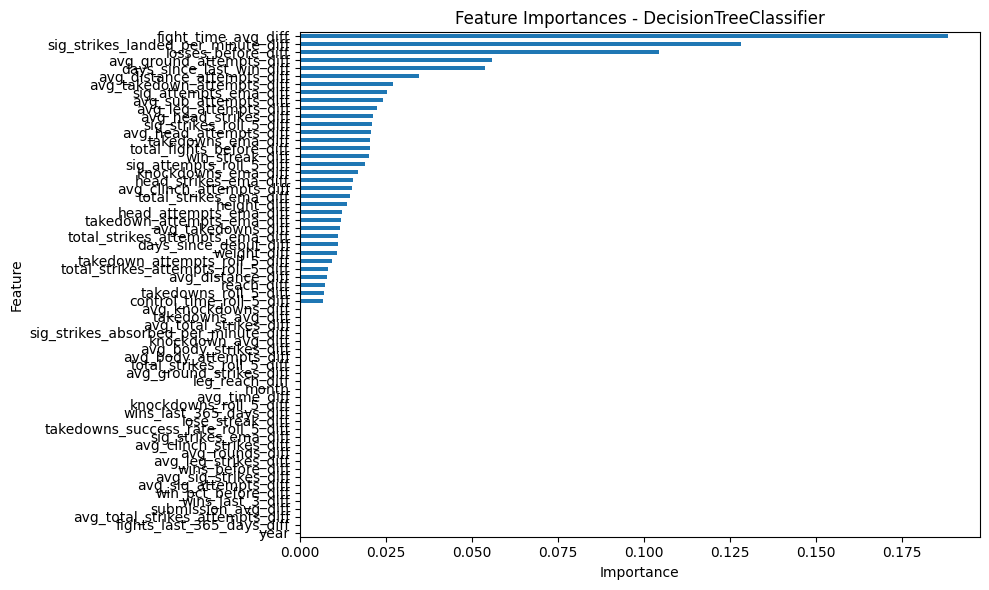

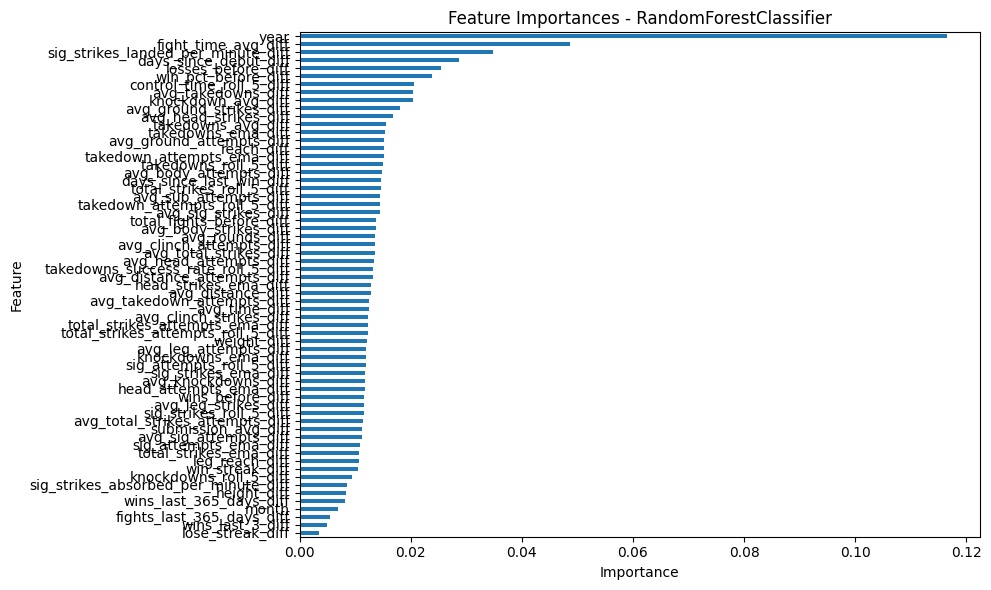

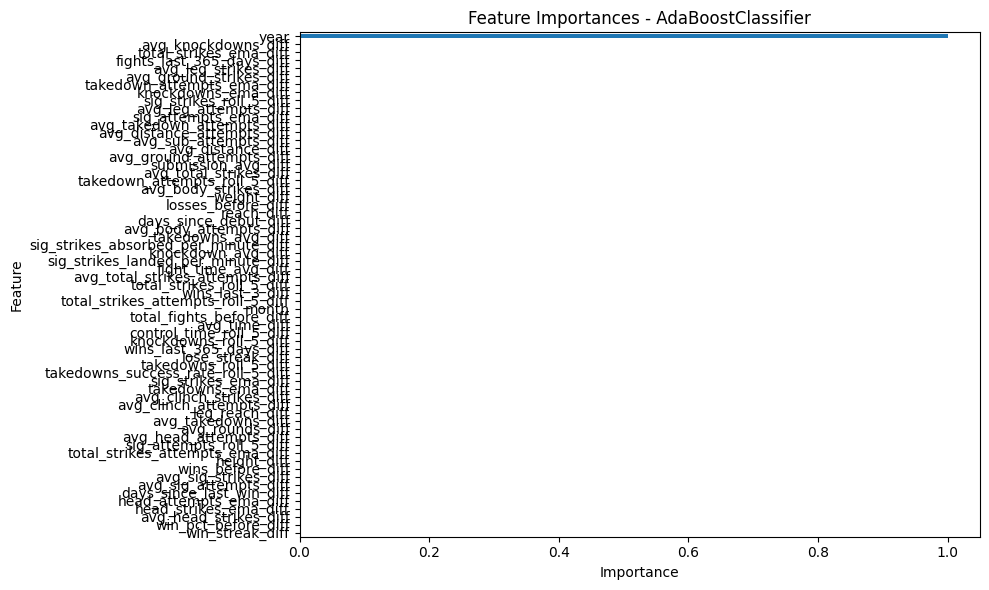

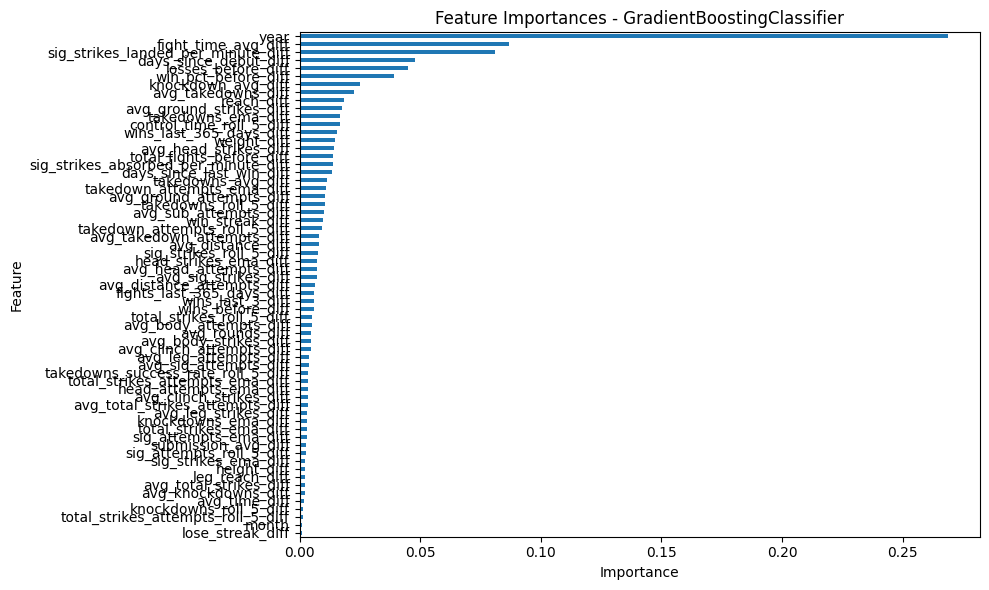

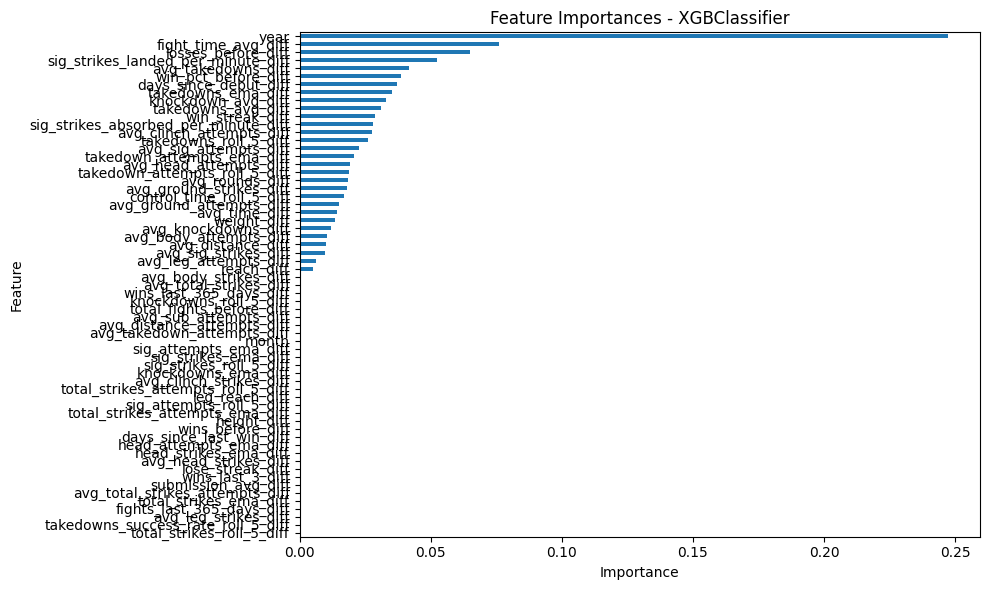

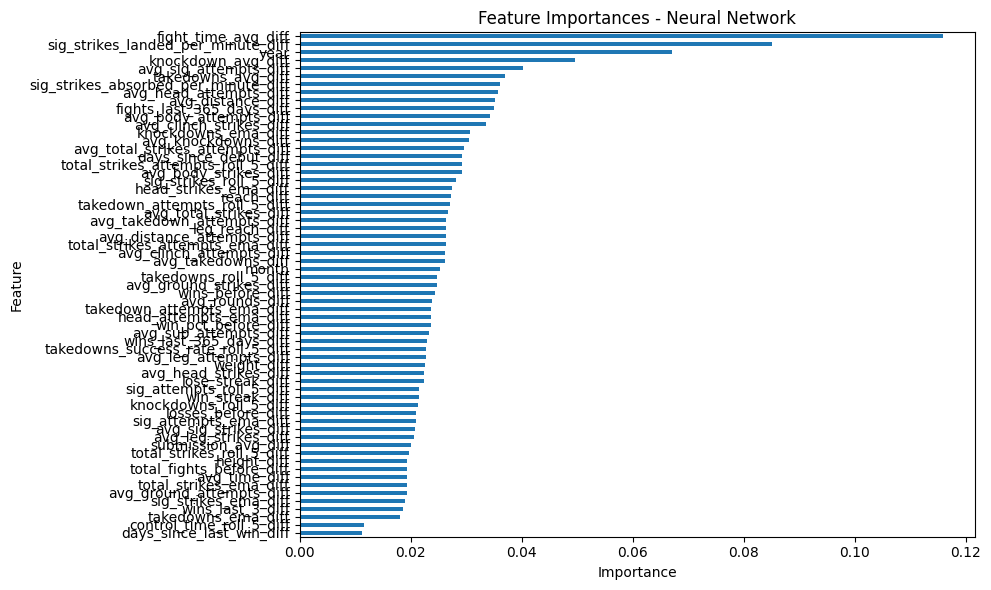

In [33]:
# Exclude 'Mean Importance' from the columns to plot
model_columns = [col for col in combined_importance_df.columns if col != "Mean Importance"]

for model_name in model_columns:
    plt.figure(figsize=(10, 6))
    combined_importance_df[model_name].sort_values(ascending=True).plot(kind='barh')
    plt.title(f'Feature Importances - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


Save the models

In [34]:
# Function to clean filename
def clean_filename(name):
    # Replace spaces and special characters with underscores
    cleaned = re.sub(r'[^\w\s-]', '', name)  # Remove special chars except spaces and hyphens
    cleaned = re.sub(r'[-\s]+', '_', cleaned)  # Replace spaces and hyphens with underscores
    return cleaned.lower()

# Save each model
saved_models = {}
for name, grid in best_models.items():
    best_model = grid.best_estimator_
    
    # Clean the model name for filename
    clean_name = clean_filename(name)
    filename = f"../models/{clean_name}.pkl"
    
    # Save the model
    with open(filename, 'wb') as f:
        pickle.dump(best_model, f)
    
    # Keep track of original name to filename mapping
    saved_models[name] = filename
    
    print(f"Saved '{name}' model to {filename}")

# Save PyTorch model
if 'pytorch_model' in locals() or 'pytorch_model' in globals():
    torch.save(pytorch_model.state_dict(), "../models/PyTorch_state_dict.pth")
    print(f"Saved PyTorch state dict to ../models/PyTorch_state_dict.pth")

Saved 'LogisticRegression' model to ../models/logisticregression.pkl
Saved 'SVC' model to ../models/svc.pkl
Saved 'SGDClassifier' model to ../models/sgdclassifier.pkl
Saved 'GaussianNB' model to ../models/gaussiannb.pkl
Saved 'KNeighborsClassifier' model to ../models/kneighborsclassifier.pkl
Saved 'DecisionTreeClassifier' model to ../models/decisiontreeclassifier.pkl
Saved 'RandomForestClassifier' model to ../models/randomforestclassifier.pkl
Saved 'AdaBoostClassifier' model to ../models/adaboostclassifier.pkl
Saved 'GradientBoostingClassifier' model to ../models/gradientboostingclassifier.pkl
Saved 'XGBClassifier' model to ../models/xgbclassifier.pkl
Saved PyTorch state dict to ../models/PyTorch_state_dict.pth
